Import Library

In [ ]:
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)
import altair as alt

Instructions for updating:
non-resource variables are not supported in the long term


Untuk menggunakan Altair ini, kita perlu mengatur parameter renderer agar visualisasi yang kita buat dapat ditampilkan secara langsung pada tools yang digunakan.

In [ ]:
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')

RendererRegistry.enable('colab')

Setelah seluruh environment telah siap digunakan, selanjutnya kita dapat mengunduh dataset dengan menggunakan kode berikut.

In [ ]:
print('Downloading movielens data...')
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print('Done. Dataset contains:')
print(zip_ref.read('ml-100k/u.info'))

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


Load masing masing dataset (users, movies, and ratings).

In [ ]:
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# Genre pada setiap film bersifat biner.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

movies_cols = [
    'movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url'
] + genre_cols

movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

Dengan menggunakan kode di atas, sekarang kita memiliki sebuah dataframe seperti berikut.

In [ ]:
users

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [ ]:
ratings

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [ ]:
movies

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Merekap jumlah dataset yang mencakup users, ratings, dan film, gunakan kode seperti berikut.

In [ ]:
print('Jumlah data film: ', len(movies.movie_id.unique()))
print('Jumlah data pengunjung: ', len(users.user_id.unique()))
print('Jumlah data penayangan: ', len(ratings.user_id))

Jumlah data film:  1682
Jumlah data pengunjung:  943
Jumlah data penayangan:  100000


Apakah Anda memperhatikan sesuatu yang kurang sesuai pada dataset di atas? Ya, masalahnya terletak pada fitur user_id dan movie_id yang dimulai dari angka satu. Untuk mempermudah proses perhitungan dan menyesuaikan dengan format komputasi yang umum digunakan, mari kita ubah urutannya agar dimulai dari nol. Selain itu, kita juga perlu mengekstrak tahun rilis dari setiap film, yang nantinya akan digunakan dalam proses pelatihan. Untuk melakukan kedua langkah ini, Anda dapat menggunakan kode berikut.

In [ ]:
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

mengetahui jumlah genre yang ada sebagai informasi tambahan ketika melakukan modelling khususnya collaborative filtering.

In [ ]:
genre_occurences = movies[genre_cols].sum().to_dict()
genre_occurences

{'genre_unknown': 2,
 'Action': 251,
 'Adventure': 135,
 'Animation': 42,
 'Children': 122,
 'Comedy': 505,
 'Crime': 109,
 'Documentary': 50,
 'Drama': 725,
 'Fantasy': 22,
 'Film-Noir': 24,
 'Horror': 92,
 'Musical': 56,
 'Mystery': 61,
 'Romance': 247,
 'Sci-Fi': 101,
 'Thriller': 251,
 'War': 71,
 'Western': 27}

karena genre masih berupa data biner, maka saya membuat sebuah fungsi yang dapat menggabungkan genre menjadi satu buah string.

In [ ]:
def mark_genres(movies, genres):
    def get_random_genre(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return np.random.choice(active)
    def get_all_genres(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return '-'.join(active)
    movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
    movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

print kolom all_genres dari dataframe movies yang sudah dibuat di kode diatas

In [ ]:
movies['all_genres']

,all_genres
0,Animation-Children-Comedy
1,Action-Adventure-Thriller
2,Thriller
3,Action-Comedy-Drama
4,Crime-Drama-Thriller
...,...
1677,Drama
1678,Romance-Thriller
1679,Drama-Romance
1680,Comedy


print dataframe movies

In [ ]:
movies

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,1995,Comedy,Animation-Children-Comedy
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,1,0,0,1995,Adventure,Action-Adventure-Thriller
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,1,0,0,1995,Thriller,Thriller
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,1995,Action,Action-Comedy-Drama
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,1,0,0,1995,Drama,Crime-Drama-Thriller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1677,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,1998,Drama,Drama
1678,1678,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,1,0,1,0,0,1998,Romance,Romance-Thriller
1679,1679,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,1,0,0,0,0,1998,Romance,Drama-Romance
1680,1680,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,1994,Comedy,Comedy


struktur dataset sekarang masih berdiri sendiri, oleh karena itu saya melakukan merging agar dataset yang ada menjadi satu buah kesatuan yang utuh.

In [ ]:
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

print dataframe movielens (dataframe yang sudah dimerging (ratings, movies, users))

In [ ]:
movielens

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,...,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,1997,Comedy,Comedy,49,M,writer,55105
1,185,301,3.0,891717742,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,...,1,0,0,1997,Mystery,Crime-Film-Noir-Mystery-Thriller,39,F,executive,00000
2,21,376,1.0,878887116,Heavyweights (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,0,...,0,0,0,1994,Comedy,Children-Comedy,25,M,writer,40206
3,243,50,2.0,880606923,Legends of the Fall (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,0,...,0,1,1,1994,Romance,Drama-Romance-War-Western,28,M,technician,80525
4,165,345,1.0,886397596,Jackie Brown (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,...,0,0,0,1997,Drama,Crime-Drama,47,M,educator,55113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,879,475,3.0,880175444,"First Wives Club, The (1996)",14-Sep-1996,NaN,http://us.imdb.com/M/title-exact?First%20Wives...,0,0,...,0,0,0,1996,Comedy,Comedy,13,M,student,83702
99996,715,203,5.0,879795543,Back to the Future (1985),01-Jan-1985,NaN,http://us.imdb.com/M/title-exact?Back%20to%20t...,0,0,...,0,0,0,1985,Sci-Fi,Comedy-Sci-Fi,36,F,administrator,44265
99997,275,1089,1.0,874795795,Sliver (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Sliver%20(1993),0,0,...,1,0,0,1993,Thriller,Thriller,21,M,student,95064
99998,12,224,2.0,882399156,101 Dalmatians (1996),27-Nov-1996,NaN,http://us.imdb.com/M/title-exact?101%20Dalmati...,0,0,...,0,0,0,1996,Comedy,Children-Comedy,47,M,educator,29206


membuat sebuah function untuk membuat format display data agar lebih mudah dipahami ketika melakukan eksplorasi data pada tahap berikutnya.

In [ ]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

EDA pada movielens dataframe

In [ ]:
users.describe(include="all")

,user_id,age,sex,occupation,zip_code
count,943,943.000,943,943,943
unique,943,NaN,2,21,795
top,0,NaN,M,student,55414
freq,1,NaN,670,196,9
mean,NaN,34.052,NaN,NaN,NaN
...,...,...,...,...,...
min,NaN,7.000,NaN,NaN,NaN
25%,NaN,25.000,NaN,NaN,NaN
50%,NaN,31.000,NaN,NaN,NaN
75%,NaN,43.000,NaN,NaN,NaN


Selanjutnya, kita akan membuat visualisasi agar dapat mempermudah proses analisis yang akan dilakukan. Namun, perlu Anda ingat kembali bahwa kita menggunakan tiga buah dataset. Oleh karena itu, untuk mempermudah proses analisis yang serupa, buatlah sebuah fungsi agar dapat digunakan berulang kali.

In [ ]:
# Membuat filter untuk melakukan slicing data
occupation_filter = alt.selection_multi(fields=["occupation"])
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme="category20")),
        alt.value("lightgray")),
).properties(width=300, height=300, selection=occupation_filter)

# Fungsi yang dapat membuat histogram dari data yang sudah difilter
def filtered_hist(field, label, filter):
    base = alt.Chart().mark_bar().encode(
        x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
        y="count()",
    ).properties(
            width=300,
    )
    return alt.layer(
        base.transform_filter(filter),
        base.encode(color=alt.value("lightgray"), opacity=alt.value(.7)),
    ).resolve_scale(y="independent")


<ipython-input-19-8e7344544a8b>:2: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  occupation_filter = alt.selection_multi(fields=["occupation"])


Jika semuanya sudah siap, mari kita mulai dari dataset ratings. Gunakan kode berikut untuk melakukan visualisasi.

In [ ]:
# Assuming you want to visualize user ratings aggregated by occupation
users_ratings = ratings.groupby('user_id').agg(
    rating_count=('rating', 'count'),
    rating_mean=('rating', 'mean')
).merge(users, on='user_id', how='left')

# Rename columns to remove spaces and ensure correct type
users_ratings = users_ratings.rename(columns={'rating count': 'rating_count', 'rating mean': 'rating_mean'})
users_ratings['rating_count'] = users_ratings['rating_count'].astype(int)  # Explicitly set type to integer


occupation_filter = alt.selection_multi(fields=["occupation"])
occupation_chart = alt.Chart(users_ratings).mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).add_selection(occupation_filter) # Move selection here
# ... (Rest of your code remains the same)
# Create a chart for the count, and one for the mean.
alt.hconcat(
    filtered_hist('rating_count', '# ratings / user', occupation_filter), # Changed field name here
    filtered_hist('rating_mean', 'mean user rating', occupation_filter), # Changed field name here
    occupation_chart,
    data=users_ratings)

<ipython-input-20-c1a9b36bdba7>:12: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  occupation_filter = alt.selection_multi(fields=["occupation"])
<ipython-input-20-c1a9b36bdba7>:20: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use add_params instead.
  ).add_selection(occupation_filter) # Move selection here


alt.HConcatChart(...)

Selain data ratings, kita juga perlu melakukan hal yang sama pada data movies dengan menggunakan kode berikut.

In [ ]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')
genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300).add_selection(genre_filter) # add selection here
# Display the number of ratings and average rating per movie.
alt.hconcat(
    filtered_hist('rating count', '# ratings / movie', genre_filter),
    filtered_hist('rating mean', 'mean movie rating', genre_filter),
    genre_chart,
    data=movies_ratings)

<ipython-input-21-d0e5d547f71b>:7: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  genre_filter = alt.selection_multi(fields=['genre'])
<ipython-input-21-d0e5d547f71b>:15: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use add_params instead.
  ).properties(height=300).add_selection(genre_filter) # add selection here


alt.HConcatChart(...)

melihat film dengan rating terbaik berdasarkan banyak review dari pelanggan.

In [ ]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=True)
 .head(10))

,title,rating count,rating mean
1681,Scream of Stone (Schrei aus Stein) (1991),1,3.000
813,"Great Day in Harlem, A (1994)",1,5.000
1446,Century (1993),1,3.000
1592,Death in Brunswick (1991),1,4.000
1451,Lady of Burlesque (1943),1,4.000
1452,Angel on My Shoulder (1946),1,2.000
1456,Love Is All There Is (1996),1,3.000
1457,"Damsel in Distress, A (1937)",1,4.000
1459,Sleepover (1995),1,3.000
1460,Here Comes Cookie (1935),1,2.000


Tampilkan rating count lebih dari 1

In [ ]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 20)
 .sort_values('rating mean', ascending=False)
 .head(10))

,title,rating count,rating mean
407,"Close Shave, A (1995)",112,4.491
317,Schindler's List (1993),298,4.466
168,"Wrong Trousers, The (1993)",118,4.466
482,Casablanca (1942),243,4.457
113,Wallace & Gromit: The Best of Aardman Animatio...,67,4.448
63,"Shawshank Redemption, The (1994)",283,4.445
602,Rear Window (1954),209,4.388
11,"Usual Suspects, The (1995)",267,4.386
49,Star Wars (1977),583,4.358
177,12 Angry Men (1957),125,4.344


Selanjutnya, kita kembali lagi ke permasalahan yang akan diselesaikan. Tujuan kita adalah membuat sebuah sistem yang dapat merekomendasikan suatu film kepada pengguna.

Diawali dengan melakukan data splitting. Untuk mencapai tujuan tersebut, tentunya kita harus melakukan split dataset seperti pada latihan-latihan sebelumnya. Jika sebelumnya kita melakukan split dataset menggunakan TensorFlow dan Scikit-Learn, sekarang waktunya melakukan eksplorasi dengan membuat sebuah fungsi yang dapat memisahkan data latih dan data testing.

Membuat sebuah fungsi data splitting

In [ ]:
def split_dataframe(df, holdout_fraction=0.1):
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

membuat sebuah fungsi sesuai dengan kondisi indices dan values yang akan kita masukkan.

In [ ]:
def build_rating_sparse_tensor(ratings_df):
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

membuat sebuah fungsi yang dapat menghitung loss menggunakan pendekatan mean square error yang telah dipelajari pada modul sebelumnya.

In [ ]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
    predictions = tf.gather_nd(
        tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
        sparse_ratings.indices)
    loss=tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

Pada kasus ini, kita akan membangun sebuah sistem rekomendasi menggunakan metode collaborative filtering model.

Tentunya kita memerlukan sebuah library yang dapat membantu proses pembangunan model tersebut, tetapi karena Anda menyukai tantangan, mari kita lupakan sejenak dan membuat sebuah kelas yang dapat mengerjakan tugas tersebut.

Kelas sederhana yang akan kita bangun berguna untuk melatih model faktorisasi matriks menggunakan penurunan gradien stokastik. Perhatikan kode berikut.

In [ ]:
class CFModel(object):
  def __init__(self, embedding_vars, loss, metrics=None):
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

Seperti yang Anda lihat, pada kode di atas terdapat beberapa konstruktor pada kelas tersebut seperti user_embeddings, movie_embeddings, loss_optimizer, dan matriks. Agar lebih mudah dimengerti, mari kita rangkum kode tersebut untuk tujuan memahami struktur kode secara keseluruhan (bukan untuk diimplementasikan).

In [ ]:
# U_var = ...
# V_var = ...
# loss = ...
# model = CFModel(U_var, V_var, loss)
# model.train(iterations=100, learning_rate=1.0)
# user_embeddings = model.embeddings['user_id']
# movie_embeddings = model.embeddings['movie_id']

TypeError: 'ellipsis' object is not iterable

Sadarkah Anda bahwa sedari tadi kita membuat fungsi, tetapi belum digunakan? Mohon bersabar karena kita harus membuat sebuah fungsi terakhir untuk membangun model sistem rekomendasi. Fungsi ini akan memanggil fungsi-fungsi sebelumnya dan akan mengembalikan sebuah dataset yang siap untuk dilatih.

In [ ]:
def build_model(ratings, embedding_dim, init_stddev):
  # Membagi dataset menjadi data latih dan data uji.
  train_ratings, test_ratings = split_dataframe(ratings)
  # Mengubah dataset menjadi SparseTensor.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Inisialisasi embedding menggunakan distribusi normal.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

Terakhir merupakan tahapan pamungkas, kita perlu melakukan pelatihan dengan memanggil seluruh fungsi yang telah dibuat sebelumnya. Karena seluruh fungsi sudah terhubung dengan baik, Anda hanya perlu membuat kode seperti berikut.

 iteration 1000: train_error=0.377281, test_error=1.360859

[{'train_error': 0.37728137, 'test_error': 1.3608594}]

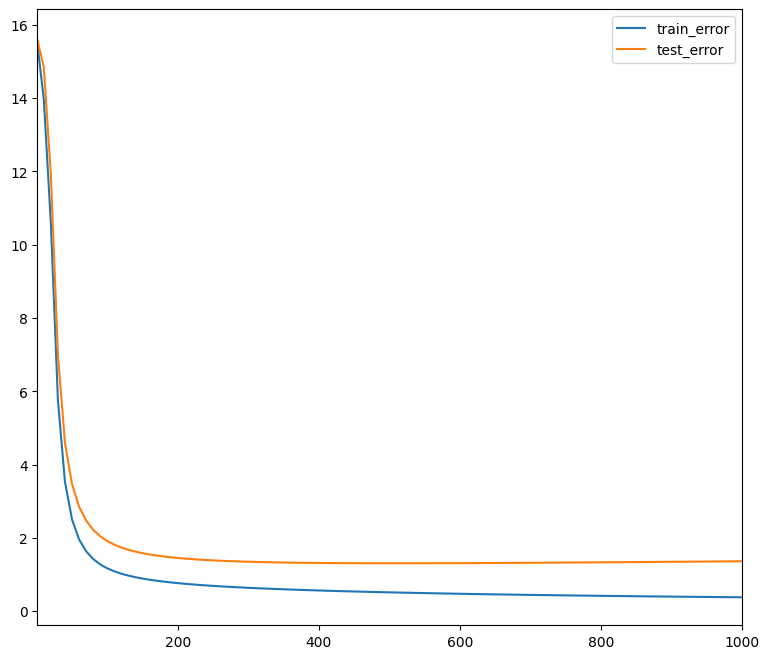

In [ ]:
model = build_model(ratings, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

Dalam sistem rekomendasi, cosine similarity lebih umum digunakan dibandingkan dot similarity karena lebih efektif dalam menangani data dengan berbagai skala dan memberikan hasil yang lebih akurat tentang kesamaan fitur. Misalnya, untuk merekomendasikan film, cosine similarity dapat digunakan untuk menemukan film yang memiliki kesamaan fitur berdasarkan preferensi pengguna, meskipun jumlah rating pengguna bervariasi.

Karena kita sudah pernah membahas detail dari pendekatan kemiripan pada modul sebelumnya, sekarang saatnya kita terjun bebas menuju pembuatan kode yang dapat menghitung skor kemiripan.

In [ ]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
    u = query_embedding
    V = item_embeddings
    if measure == COSINE:
        V = V / np.linalg.norm(V, axis=1, keepdims=True)
        u = u / np.linalg.norm(u)
    scores = u.dot(V.T)
    return scores

Fungsi di atas akan menghitung skor kesamaan antara data user dan item yang sudah melewati tahapan embedding menggunakan dua jenis ukuran kesamaan yaitu konstanta dot product dan cosine similarity.

Sampai di sini, model yang Anda bangun belum menghasilkan rekomendasi sama sekali. Hal ini karena kita belum membangun sebuah sintaks atau fungsi yang dapat melakukan inference berdasarkan model yang sudah dibuat.

Untuk melakukan inference pada model collaborative filtering, kita bisa menggunakan dua pendekatan yaitu memberikan rekomendasi berdasarkan pengguna terdekat dan film terdekat. Mari kita bahas mulai dari pengguna terdekat.

In [ ]:
def user_recommendations(model, measure=DOT, exclude_rated=True, k=6):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["user_id"][942], model.embeddings["movie_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    if exclude_rated:
        # Menghapus film yang sudah diberikan rating oleh user.
        rated_movies = ratings[ratings.user_id == "942"]["movie_id"].values
        df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
    display.display(df.sort_values([score_key], ascending=False).head(k))

Mari kita lihat output dari penggunaan fungsi berikut.

In [ ]:
USER_RATINGS = True
user_recommendations(model, measure=COSINE, k=5)
user_recommendations(model, measure=DOT, k=5)

,cosine score,movie_id,titles,genres
1609,0.700,1609,"Truth or Consequences, N.M. (1997)",Action-Crime-Romance
143,0.685,143,Die Hard (1988),Action-Thriller
222,0.671,222,Sling Blade (1996),Drama-Thriller
146,0.648,146,"Long Kiss Goodnight, The (1996)",Action-Thriller
677,0.643,677,Volcano (1997),Drama-Thriller


,dot score,movie_id,titles,genres
959,6.522,959,Naked (1993),Drama
1325,5.922,1325,Boys (1996),Drama
260,5.804,260,Air Bud (1997),Children-Comedy
248,5.608,248,Austin Powers: International Man of Mystery (1...,Comedy
143,5.584,143,Die Hard (1988),Action-Thriller


Seperti yang Anda lihat pada output di atas, model kita dapat memberikan rekomendasi film yang sesuai dengan rating yang diberikan oleh pengguna dengan ID 942. Lalu, bagaimana cara kita mendapatkan rekomendasi berdasarkan fitur lainnya? Pada kasus ini, kita dapat membuat rekomendasi berdasarkan kemiripan genre dari masing-masing film. Perhatikan fungsi berikut.

In [ ]:
def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Mencari film berdasarkan judul yang dimasukkan.
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

Dengan membuat fungsi di atas, kita dapat memberikan rekomendasi kepada pengguna berdasarkan genre dari judul film yang pernah ditonton olehnya. Untuk menggunakan fungsi tersebut, Anda dapat mengikuti kode di bawah ini.

In [ ]:
movie_neighbors(model, "Star Wars", DOT)
movie_neighbors(model, "Star Wars", COSINE)

Nearest neighbors of : Star Wars (1977).


,dot score,titles,genres
49,7.891,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
171,7.105,"Empire Strikes Back, The (1980)",Action-Adventure-Drama-Romance-Sci-Fi-War
180,6.908,Return of the Jedi (1983),Action-Adventure-Romance-Sci-Fi-War
173,6.665,Raiders of the Lost Ark (1981),Action-Adventure
194,6.475,"Terminator, The (1984)",Action-Sci-Fi-Thriller
115,6.413,Cold Comfort Farm (1995),Comedy


Nearest neighbors of : Star Wars (1977).


,cosine score,titles,genres
49,1.000,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
180,0.950,Return of the Jedi (1983),Action-Adventure-Romance-Sci-Fi-War
171,0.929,"Empire Strikes Back, The (1980)",Action-Adventure-Drama-Romance-Sci-Fi-War
209,0.888,Indiana Jones and the Last Crusade (1989),Action-Adventure
256,0.881,Men in Black (1997),Action-Adventure-Comedy-Sci-Fi
203,0.874,Back to the Future (1985),Comedy-Sci-Fi
